# Indicateurs intégrité des données IRVE

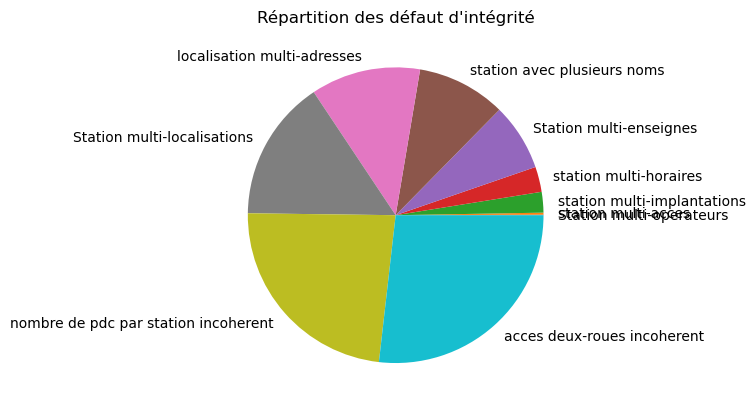

In [4]:
date = '2023-03-03'
date = '2023-04-17'
indic, irve_p, irve_s = set_indicateurs(date)
defaut_integrite(indic)

In [5]:
indic = []
with open('indic.txt', 'r', encoding="utf-8") as f:
    for line in f:
        indic.append(json.loads(line))
log = []
with open('logfile.txt', 'r', encoding="utf-8") as f:
    for line in f:
        log.append(json.loads(line))
'''nb pdc total
nb pdc incorrects
% incorrects

nb stations
nb stations incorrectes
% incorrects'''

{'date_irve': '2023-03-03', 'file': 'IRVE_itinerance_residuel2023-03-03.csv', 'chemin': 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/', 'Pdc non unique': 0, 'Station multi-operateurs': 0, 'Station multi-enseignes': 267, 'Station multi-localisations': 216, 'Pdc multi-stations': 0, 'station avec plusieurs noms': 40, 'station multi-implantations': 23, 'nombre de pdc par station incoherent': 452, 'station multi-acces': 0, 'station multi-horaires': 53, 'acces deux-roues incoherent': 325, 'localisation multi-adresses': 414, 'principal pdc': 475, 'secondaire pdc': 1141, 'principal stat': 179, 'secondaire stat': 289}
{'date_irve': '2023-03-03', 'file': 'IRVE_itinerance_residuel2023-03-03.csv', 'chemin': 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/', 'Pdc non unique': 0, 'Station multi-operateurs': 0, 'Station multi-enseignes': 267, 'Station multi-localisations': 216, 'Pd

'nb pdc total\nnb pdc incorrects\n% incorrects\n\nnb stations\nnb stations incorrectes\n% incorrects'

In [6]:
defaut_carte(irve_p, irve_s).show('irve.html')

## Annexe - Fonctions utilisées

In [7]:
import pandas as pd
import json

def set_indicateurs(date):
    indic = {'date_irve': date, 'file': 'IRVE_itinerance_residuel' + date + '.csv',
          'chemin': 'https://raw.githubusercontent.com/loco-philippe/Environmental-Sensing/main/python/Validation/irve/Analyse/'}
    irve = pd.read_csv(indic['chemin'] + indic['file'], sep=',', low_memory=False)
    total = len(irve)
    check = list(irve.columns)[17:]
    regles = ['Pdc non unique', 'Station multi-operateurs', 'Station multi-enseignes', 'Station multi-localisations', 
              'Pdc multi-stations', 'station avec plusieurs noms', 'station multi-implantations', 
              'nombre de pdc par station incoherent', 'station multi-acces', 'station multi-horaires', 
              'acces deux-roues incoherent', 'localisation multi-adresses']
    principal = [17, 18, 19, 20, 21]
    secondaire = [22, 23, 24, 25, 26, 27, 28]

    irve['principal'] = True
    for ind in principal:
        irve['principal'] &= irve.iloc[:,ind]
        indic[regles[ind-17]] = int(total - irve.iloc[:,ind].sum())
    irve['secondaire'] = True
    for ind in secondaire:
        irve['secondaire'] &= irve.iloc[:,ind]
        indic[regles[ind-17]] = int(total - irve.iloc[:,ind].sum())
    irve['secondaire'] |= (~irve['principal'] & ~irve['secondaire'])
    irve['verif'] = irve['principal'] & irve['secondaire']
    indic['principal pdc'] = int(total - irve['principal'].sum())
    indic['secondaire pdc'] = int(total - irve['secondaire'].sum())

    irve_p = irve[~irve['principal']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    irve_s = irve[~irve['secondaire']].drop_duplicates('id_station_itinerance').reset_index(drop=True)
    indic['principal stat'] = len(irve_p)
    indic['secondaire stat'] = len(irve_s)
    with open('indic.txt', 'a', encoding="utf-8") as f:
        f.write(json.dumps(indic) + '\n')
    return (indic, irve_p, irve_s)

In [8]:
import matplotlib.pyplot as plt

def defaut_integrite(indic):
    #val = { regles[ind-17]: indic[regles[ind-17]] for ind in range(17,29) if indic[regles[ind-17]] > 0 }
    val = dict(item for ind, item in enumerate(indic.items()) if 2 < ind < 15 and item[1] > 0)
    val = dict(sorted(val.items(), key=lambda item:item[1], reverse=False))
    fig, ax = plt.subplots()
    ax.pie(list(val.values()), labels=list(val.keys()))
    ax.set_title("Répartition des défauts d'intégrité")
    plt.show()  

In [9]:
from util_carto import Cart

def defaut_carte(irve_p, irve_s):
    popup = [[], []]
    locat = [[], []]
    for ind, irve in enumerate((irve_p, irve_s)):
        for i in range(len(irve)):
            popup[ind].append( {'id_station': irve['id_station_itinerance'][i], 
                               'id_pdc': irve['id_pdc_itinerance'][i],
                               'contact_operateur': irve['contact_operateur'][i],
                               'nom_enseigne': irve['nom_enseigne'][i],
                               'nom_station': irve['nom_station'][i],
                               'adresse_station': irve['adresse_station'][i],
                               'fichier des écarts': '<a href="https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/">IRVE_itinerance_residuel</a>' } )
            coord = json.loads(irve['coordonneesXY'][i])
            coord.reverse()
            locat[ind].append(coord)

    cart = Cart([50, 2.5])
    cart.add_markers(locat[0], popup=popup[0], color='red', group='écarts entités', max_width=250)
    cart.add_markers(locat[1], popup=popup[1], color='orange', group='écarts attributs', max_width=250, icon='bug')
    return cart